In [1]:
import pandas as pd
import numpy as np
import os
import sys
import scipy
import seaborn as sns
from matplotlib import pyplot as plt
import cv2

sys.path.append(os.path.abspath('..'))

from utils.utils_constants import (VESSEL_NEPTUNE_PAT_INFO_W_SCORE_PATH as VESSEL_PAT_INFO_W_SCORE_PATH,
                                   ARTERY_TYPES, CLASSIFICATION_SEVERITY_MAPPING,
                                   CLASSIFICATION_PATH, MEASUREMENTS_PATH, FEATURES_PATH,
                                   CROPPED_VESSELS_DIR)


from utils.utils_data import read_df_from_json, get_classifications
from utils.utils_post_process import post_process
from utils.utils_feature import extract_features

import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [2]:
pat_df = pd.read_csv(VESSEL_PAT_INFO_W_SCORE_PATH)
pat_df.shape

(247, 87)

In [3]:
def count_gt_zero(lst):
    return sum(x > 0 for x in lst)

def clean(combined_measurements):
    combined_measurements = combined_measurements.reset_index(drop=True)
    for col in ['Arteriosclerosis Severity', 'Hyalinosis Severity']:
        combined_measurements[col] = combined_measurements[col].map(CLASSIFICATION_SEVERITY_MAPPING)
    combined_measurements.loc[:, "WSI_Fake_Name"] = combined_measurements.loc[:, "Image Name"].str[:18]
    return combined_measurements

combined_measurements = read_df_from_json(MEASUREMENTS_PATH)
combined_measurements = clean(combined_measurements)

In [4]:
def get_hya_seg_area(img_name):
    save_dir = "/DataMount/NEPTUNE/Cropped_Vessels_Combined_Pred_Hyalinosis/"
    img_path = os.path.join(save_dir, img_name.replace(".png", "_pred_hya_20240706-234141_epoch_50_processed.png"))
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    return np.sum(img)

def extract_features_from_measurements(measurements):
    img_name = measurements["Image Name"].iloc[0]
    features = {}

    artery_area = measurements["Area_Media"].iloc[0] + measurements["Area_Intima"].iloc[0] + measurements["Area_Lumen"].iloc[0]
    # Calculate area ratios
    features["Artery Area"] = artery_area
    features["Lumen Area"] = measurements["Area_Lumen"].iloc[0]
    features["Intima Area Ratio"] = measurements["Area_Intima"].iloc[0] / artery_area
    features["Media Area Ratio"] = measurements["Area_Media"].iloc[0] / artery_area
    features["Lumen Area Ratio"] = measurements["Area_Lumen"].iloc[0] / artery_area
    features["Hyalinosis Area Ratio"] = measurements["Area_Hys"].iloc[0] / artery_area

    hya_seg_area = get_hya_seg_area(img_name)

    features["Pred Hyalinosis Area Ratio"] = hya_seg_area / artery_area
    # Initialize arrays for ratio calculations
    all_media = []
    all_intima = []
    all_ratio = []

    # Iterate over each row in the measurement DataFrame
    for _, m in measurements.iterrows():
        m_media = np.array(m["Thickness_Media"])
        m_intima = np.array(m["Thickness_Intima"])

        # Example processing assuming m_media and m_intima are arrays
        m_wall = np.array([x + y if x >= 0 else x for x, y in zip(m_media, m_intima)])

        m_media, m_intima, m_ratio = post_process(m_media, m_intima, m_wall,
                                                  t_multi=15, t_open_lumen=30, t_mediam=15, t_average=15, 
                                                  artery_area=artery_area)
        all_media.extend(m_media)
        all_intima.extend(m_intima)
        all_ratio.extend(m_ratio)

    if -2 in all_media: 
        features["Cutting Type"] = 1
    elif -3 in all_media:
        features["Cutting Type"] = 2
    else:
        features["Cutting Type"] = 0
    # Assuming all_media and all_intima are lists of arrays, we concatenate them to perform a global calculation
    features_intima, features_media, features_ratio = extract_features(all_media, all_intima, all_ratio)
    features = {**features, **features_intima, **features_media, **features_ratio}
    return features

available_sheetnames = pd.ExcelFile(CLASSIFICATION_PATH).sheet_names
combined_features = []

excel_writer = pd.ExcelWriter(FEATURES_PATH, engine='xlsxwriter')

for i, (index, row_case) in enumerate(pat_df.iterrows()):
    slide_filename = row_case["WSI_Selected"]
    slide_basename = os.path.splitext(slide_filename)[0]
    logging.info(f"Processing: {i+1}/{len(pat_df)} {slide_filename}")

    classifications = get_classifications(CLASSIFICATION_PATH, slide_basename, available_sheetnames)
    if classifications.empty:
        continue  # Skip to if no relevant data
    classifications['Artery Type'] = pd.Categorical(classifications['Artery Type'], categories=ARTERY_TYPES)
    for col in ['Arteriosclerosis Severity', 'Hyalinosis Severity']:
        classifications[col] = classifications[col].map(CLASSIFICATION_SEVERITY_MAPPING)

    features_case = []
    for i, (_, row_vessel)in enumerate(classifications.iterrows()):
        measurements = combined_measurements.loc[combined_measurements.loc[:, "Image Name"] == row_vessel["Image Name"]]
        if measurements.empty:
            continue
        features_vessel = extract_features_from_measurements(measurements)
        features_vessel.update(row_vessel)
        features_case.append(features_vessel)
    features_case = pd.DataFrame(features_case)
    features_case.to_excel(excel_writer, sheet_name=slide_basename, index=False)
    worksheet = excel_writer.sheets[slide_basename]
    for i, col in enumerate(features_case.columns):
        # Set the column width
        column_len = max(features_case[col].astype(str).apply(len).max(), len(col)) + 2  # Adding a little extra space
        worksheet.set_column(i, i, column_len)
    logging.info(f"Saved sheet for {slide_basename} with {len(features_case)} entries.")
    combined_features.append(features_case)
    
excel_writer.close()
logging.info("Excel file with differentiated sheets saved successfully.")

2024-07-08 01:50:05,405 - INFO - Processing: 1/247 10_26609_000_002_L2_TRI.svs
2024-07-08 01:50:06,737 - INFO - Saved sheet for 10_26609_000_002_L2_TRI with 12 entries.
2024-07-08 01:50:06,740 - INFO - Processing: 2/247 11_26609_000_009_L2_TRI.svs
2024-07-08 01:50:09,506 - INFO - Saved sheet for 11_26609_000_009_L2_TRI with 25 entries.
2024-07-08 01:50:09,509 - INFO - Processing: 3/247 11_26609_000_012_L02_TRI.svs
2024-07-08 01:50:10,473 - INFO - Saved sheet for 11_26609_000_012_L02_TRI with 5 entries.
2024-07-08 01:50:10,475 - INFO - Processing: 4/247 11_26609_000_013_L02 TRI.svs
2024-07-08 01:50:11,602 - INFO - Saved sheet for 11_26609_000_013_L02 TRI with 11 entries.
2024-07-08 01:50:11,605 - INFO - Processing: 5/247 0_784_A_0047801.svs
2024-07-08 01:50:13,462 - INFO - Saved sheet for 0_784_A_0047801 with 18 entries.
2024-07-08 01:50:13,466 - INFO - Processing: 6/247 0_796_A_0047806.svs
2024-07-08 01:50:15,985 - INFO - Saved sheet for 0_796_A_0047806 with 28 entries.
2024-07-08 01:5

In [5]:
combined_features_df = pd.concat(combined_features, axis=0)
combined_features_df.to_csv(FEATURES_PATH.replace(".xlsx", "_combined.csv"), index=False)

In [6]:
combined_features_df = pd.read_csv(FEATURES_PATH.replace(".xlsx", "_combined.csv"))
combined_features_df

,Artery Area,Lumen Area,Intima Area Ratio,Media Area Ratio,Lumen Area Ratio,Hyalinosis Area Ratio,Pred Hyalinosis Area Ratio,Cutting Type,Intima Average,Intima Median,...,Ratio Variance,Vis Ratio Peak Indice,Ratio Peak Height,Ratio Peak Prominence,Image Name,Artery ID,Bounding Box,Artery Type,Arteriosclerosis Severity,Hyalinosis Severity
0,61749.0,26277.0,0.126998,0.447457,0.425545,0.0,0.0,1,0.073192,0.068930,...,0.003766,232.0,0.397297,0.397297,Biopsy_001_WSI_001_A01_87467_29252_539_387.png,A01,"87467, 29252, 539, 387",Interlobular Arteries,0,0
1,100195.5,14797.0,0.090428,0.761891,0.147681,0.0,0.0,0,0.044150,0.047341,...,0.009101,302.0,0.430258,0.351727,Biopsy_001_WSI_001_A02_86515_28505_861_584.png,A02,"86515, 28505, 861, 584",Interlobular Arteries,0,0
2,282556.5,52704.5,0.252452,0.561021,0.186527,0.0,0.0,2,0.062841,0.062405,...,0.019992,598.0,0.715234,0.681892,Biopsy_001_WSI_001_A04_83812_19882_846_1293.png,A04,"83812, 19882, 846, 1293",Interlobular Arteries,0,0
3,15934.5,2685.0,0.185384,0.646114,0.168502,0.0,0.0,0,0.097852,0.079516,...,0.011658,249.0,0.546768,0.317191,Biopsy_001_WSI_001_A05_85633_16311_186_182.png,A05,"85633, 16311, 186, 182",Arterioles,0,0
4,21118.0,4192.5,0.225945,0.575528,0.198527,0.0,0.0,0,0.108965,0.098914,...,0.011444,77.0,0.584382,0.349198,Biopsy_001_WSI_001_A06_83026_12349_173_255.png,A06,"83026, 12349, 173, 255",Arterioles,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2314,444319.0,202370.5,0.179833,0.364705,0.455462,0.0,0.0,0,0.061169,0.052798,...,0.013696,105.0,0.599115,0.389129,Biopsy_294_WSI_001_A11_124595_21287_832_1169.png,A11,"124595, 21287, 832, 1169",Interlobular Arteries,0,1
2315,480758.0,258415.0,0.121528,0.340956,0.537516,0.0,0.0,0,0.039631,0.036188,...,0.029921,339.0,0.993866,0.993866,Biopsy_294_WSI_001_A10_124055_28182_1098_807.png,A10,"124055, 28182, 1098, 807",Interlobular Arteries,0,0
2316,65877.0,25077.0,0.146326,0.473010,0.380664,0.0,0.0,1,0.069411,0.063913,...,0.008697,108.0,0.459243,0.313397,Biopsy_294_WSI_001_A08_123976_34227_369_456.png,A08,"123976, 34227, 369, 456",Interlobular Arteries,0,0
2317,95817.5,11462.5,0.180520,0.699851,0.119628,0.0,0.0,2,0.045007,0.038026,...,0.006242,99.0,0.453723,0.348428,Biopsy_294_WSI_001_A07_121983_39679_253_716.png,A07,"121983, 39679, 253, 716",Arterioles,0,1


In [7]:
def violin_plots(df, feature_name, severity_type, plot_style, ax):
    features = df.loc[:, feature_name].values
    scores = df.loc[:, severity_type].values

    rho, p_val = scipy.stats.pearsonr(features, scores)
    p_str = f"p<0.0001" if p_val < 0.0001 else f"p={p_val:.3f}"
    # Convert 'Score' to category if not already
    data = pd.DataFrame({'Score': scores, 'Feature Value': features})
    data['Score'] = pd.Categorical(data['Score'], categories=[0, 1, 2, 3], ordered=True)
    if plot_style == "violin":
        sns.violinplot(x='Score', y='Feature Value', data=data, ax=ax, order=[0, 1, 2, 3])
    elif plot_style == "box":
        sns.boxplot(x='Score', y='Feature Value', data=data, ax=ax, order=[0, 1, 2, 3])
    ax.set_xlabel(severity_type, fontsize=15)
    ax.set_ylabel("Feature Value", fontsize=15)
    ax.set_title(f"{feature_name}\n$\\gamma_{{\\rho}}$={rho:.2f} {p_str}",
                 y=-0.4, pad=-14, fontsize=18)    
    

def gallery_view(images, titles, cols=5):
    # Number of images to show per page/view
    num_images = len(images)
    rows_per_view = 1  # Show one row at a time

    # Calculate the number of views needed
    total_views = (num_images + cols - 1) // cols

    for view in range(total_views):
        start_index = view * cols
        end_index = min(start_index + cols, num_images)
        fig, axs = plt.subplots(rows_per_view, cols, figsize=(15, 5 * rows_per_view))
        axs = axs.ravel()
        for i in range(cols):
            index = start_index + i
            if index < end_index:
                image = images[index]
                # Rotate image if width is greater than height
                if image.shape[1] > image.shape[0]:  # image.shape gives (height, width, channels)
                    image = np.rot90(image)  # Rotate 90 degrees
                axs[i].imshow(image)
                axs[i].set_title(titles[index], fontsize=18)
                axs[i].axis('off')
            else:
                axs[i].axis('off')
        plt.tight_layout()
        # Save the figure to file
        plt.show()

In [10]:
feature_names = [
    # 'Intima Area Ratio',
#  'Media Area Ratio',
 'Pred Hyalinosis Area Ratio',
 'Hyalinosis Area Ratio',
 'Intima Average',
 'Intima Median',
#  'Intima Variance',
#  'Intima Peak Height',
 'Intima Peak Prominence',
#  'Media Average',
#  'Media Median',
#  'Media Variance',
#  'Media Peak Height',
#  'Media Peak Prominence',
 'Ratio Average',
 'Ratio Median',
#  'Ratio Variance',
 'Ratio Peak Height',
#  'Ratio Peak Prominence'
 ]

2024-07-08 01:55:05,994 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-07-08 01:55:06,000 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-07-08 01:55:06,033 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-07-08 01:55:06,038 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-07-08 01:55:06,068 - INFO - Using categorical units to plot a list of strings that are all parsable as 

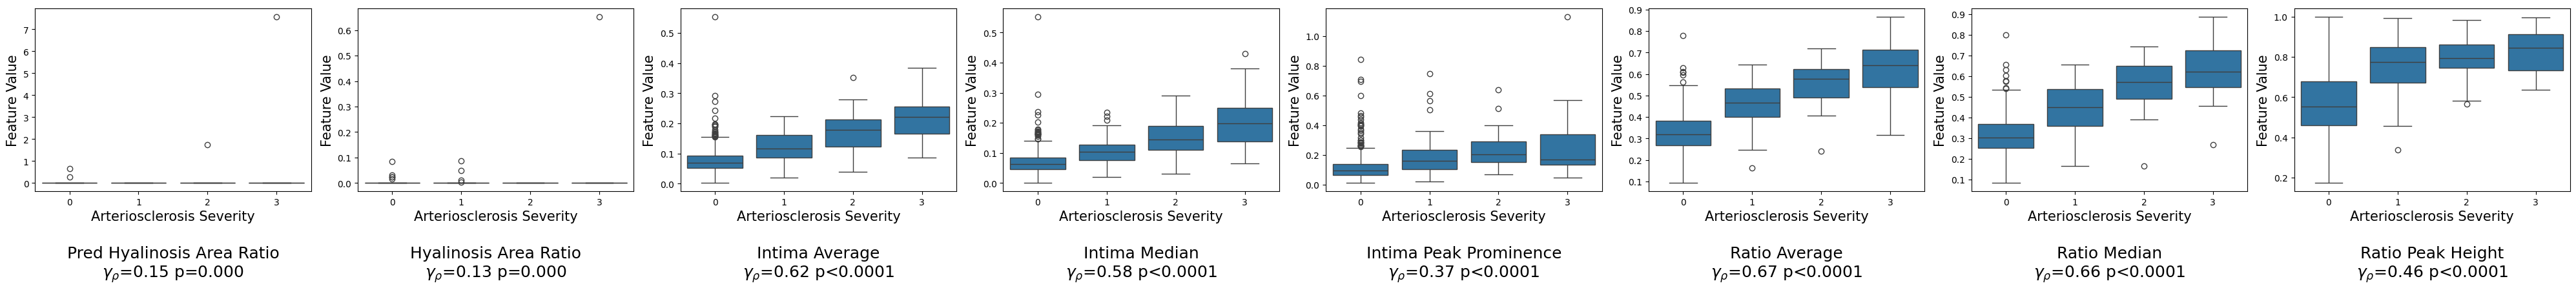

In [11]:
artery_type = "Interlobular Arteries"
severity_type = "Arteriosclerosis Severity"
# feature_names = [x for x in combined_features_df.columns if x.startswith("Intima", "Ratio", "Hyalinosis Area")]

fig, axs = plt.subplots(1, len(feature_names), figsize=(5*len(feature_names), 5))  
for i, feature_name in enumerate(feature_names):
    combined_features_df_selected = combined_features_df.loc[combined_features_df["Artery Type"]==artery_type, :]
    violin_plots(combined_features_df_selected, feature_name, severity_type, plot_style ="box", ax=axs[i])  
plt.tight_layout()
plt.show()

2024-07-08 01:55:43,374 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-07-08 01:55:43,381 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-07-08 01:55:43,418 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-07-08 01:55:43,423 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-07-08 01:55:43,454 - INFO - Using categorical units to plot a list of strings that are all parsable as 

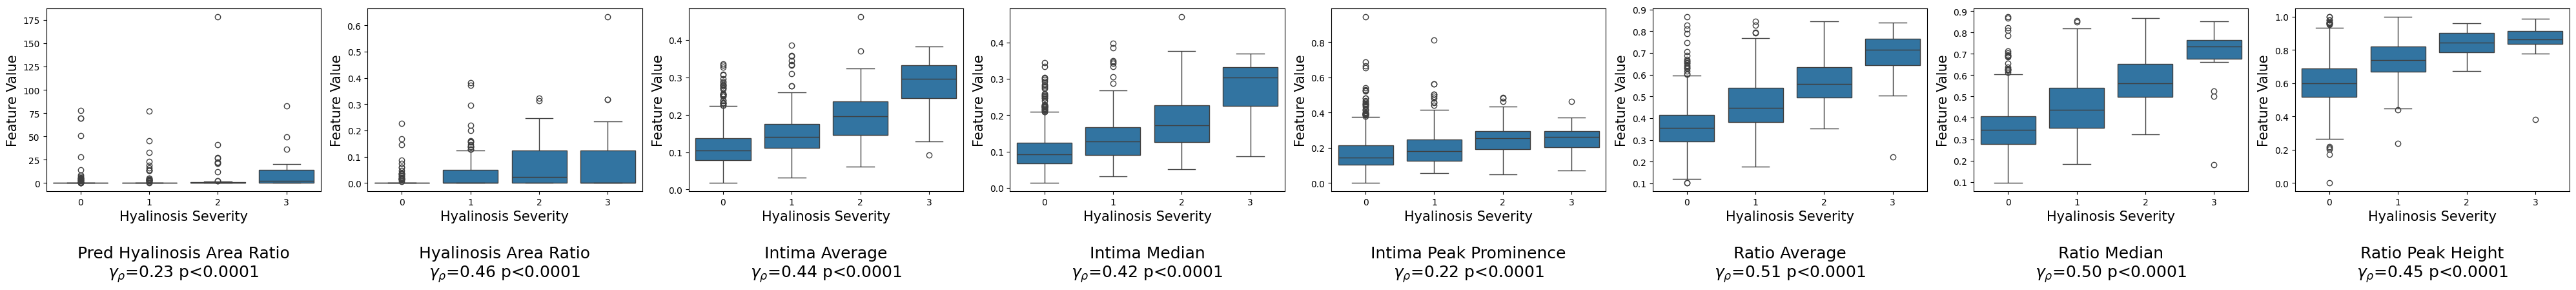

In [13]:
artery_type = "Arterioles"
severity_type = "Hyalinosis Severity"
# feature_names = [x for x in combined_features_df.columns if x.startswith("Lumen", "Intima", "Media", "Hyalinosis Area")]

fig, axs = plt.subplots(1, len(feature_names), figsize=(5*len(feature_names), 5))  
for i, feature_name in enumerate(feature_names):
    combined_features_df_selected = combined_features_df.loc[(combined_features_df["Artery Type"]==artery_type), :]
    violin_plots(combined_features_df_selected, feature_name, severity_type, plot_style ="box", ax=axs[i])  
plt.tight_layout()
plt.show()

In [ ]:
# images = []
# titles = []
# combined_features_df_selected = combined_features_df.loc[(combined_features_df["Artery Type"]==artery_type)
#                                                          &(combined_features_df["Arteriosclerosis Severity"]>0)
#                                                          &(combined_features_df["Hyalinosis Severity"]==0), :]
# print(combined_features_df_selected.shape)
# for index, row in combined_features_df_selected.iterrows():
#     image_name = row["Image Name"]
#     image_path = os.path.join(CROPPED_VESSELS_DIR, "Arterioles", image_name.replace(".png", "_w_ann.png"))
#     img = cv2.imread(image_path, cv2.IMREAD_COLOR)
#     if img is not None:
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
#         images.append(img)
#         # title = f"B{image_name.split('_')[1]}{row['Artery ID']}-AS: {row['Arteriosclerosis Severity']}; HS: {row['Hyalinosis Severity']}; LR: {row['Lumen Area Ratio']:.2f}"
#         title = f"AS: {row['Arteriosclerosis Severity']}; HS: {row['Hyalinosis Severity']}; LR: {row['Lumen Area Ratio']:.2f}"
#         titles.append(title)
# gallery_view(images, titles, cols=5)

In [ ]:
# artery_type = "Arterioles"
# severity_type = "Hyalinosis Severity"
# feature_names = ["Artery Area", "Lumen Area", "Lumen Area Ratio"]

# fig, axs = plt.subplots(1, len(feature_names), figsize=(5*len(feature_names), 5))  
# for i, feature_name in enumerate(feature_names):
#     violin_plots(combined_features_df.loc[combined_features_df["Artery Type"]==artery_type, :], feature_name, 
#                  severity_type, plot_style ="box", ax=axs[i])  
# plt.tight_layout()  #
# plt.show()

# min_value = combined_features_df.loc[(combined_features_df["Artery Type"] == artery_type) & (combined_features_df[severity_type] == 3), 
#                                   "Lumen Area Ratio"].min()
# min_value

In [ ]:


images = []
titles = []
min_value = 0.05
for index, row in combined_features_df[(combined_features_df["Artery Type"] == "Arterioles") & (combined_features_df["Cutting Type"] == 1)].iterrows():
    image_name = row["Image Name"]
    image_path = os.path.join(CROPPED_VESSELS_DIR, "Arterioles", image_name.replace(".png", "_w_ann.png"))
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
        images.append(img)
        # title = f"B{image_name.split('_')[1]}{row['Artery ID']}-AS: {row['Arteriosclerosis Severity']}; HS: {row['Hyalinosis Severity']}; LR: {row['Lumen Area Ratio']:.2f}"
        title = f"AS: {row['Arteriosclerosis Severity']}; HS: {row['Hyalinosis Severity']}; LR: {row['Lumen Area Ratio']:.2f}"
        titles.append(title)
print(len(images))
gallery_view(images, titles, cols=5)

In [ ]:
available_sheetnames = pd.ExcelFile(FEATURES_PATH).sheet_names

for i, (index, row_case) in enumerate(pat_df.iterrows()):
    slide_filename = row_case["WSI_Selected"]
    slide_basename = os.path.splitext(slide_filename)[0]
    logging.info(f"Processing: {i+1}/{len(pat_df)} {slide_filename}")

    features_case = get_classifications(FEATURES_PATH, slide_basename, available_sheetnames)
    if features_case.empty:
        continue  # Skip to if no relevant data
    features_names = [x for x in features_case.columns if x.startswith(("Intima", "Media", "Ratio", "Hyalinosis Area"))]
    for feature_name in features_names:
        for artery_type in ARTERY_TYPES:
            features_series = features_case[(features_case['Artery Type'] == artery_type)
                                            & (features_case["Cutting Type"] == 0)
                                            & (features_case["Lumen Area Ratio"] >= 0.2)][feature_name]
            if not features_series.empty:
                # Calculating various statistics
                max_severity = features_series.max()
                mean_severity = features_series.mean()
                median_severity = features_series.median()
                percentile_75th = features_series.quantile(0.75)
                percentile_25th = features_series.quantile(0.25)
            else:
                max_severity = mean_severity = median_severity = percentile_75th = percentile_25th =  -1  # or another indicator for no data

            # Storing these values in the DataFrame
            pat_df.loc[index, f'Max_{feature_name}_in_{artery_type}'.replace(" ", "_")] = max_severity
            pat_df.loc[index, f'Mean_{feature_name}_in_{artery_type}'.replace(" ", "_")] = mean_severity
            pat_df.loc[index, f'Median_{feature_name}_in_{artery_type}'.replace(" ", "_")] = median_severity
            pat_df.loc[index, f'75th_{feature_name}_in_{artery_type}'.replace(" ", "_")] = percentile_75th
            pat_df.loc[index, f'25th_{feature_name}_in_{artery_type}'.replace(" ", "_")] = percentile_25th

pat_df.to_csv(VESSEL_NEPTUNE_PAT_INFO_W_SCORE_W_FEATURE_PATH, index=False)

In [ ]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
# import necessary packages

import os
import sys

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import scipy
import seaborn as sns
from scipy.stats import norm
import openslide

sys.path.append(os.path.abspath('..'))
from utils.utils_stat_process import post_process
from utils.utils_stat_feature import extract_features
from utils.classification_utils import get_classifications, get_segmentations, get_contours

from utils.image_utils import plot_artery_ann, save_image


In [ ]:
from sklearn.tree import DecisionTreeRegressor
feature_names = ["Ratio Average", "Ratio Peak Height"]
regr = DecisionTreeRegressor(max_depth=2, random_state=0)
X = combined_features[feature_names].values  # Correct extraction of features
for label_name in ['Arteriosclerosis Severity', 'Hyalinosis Severity']:
    y = combined_features[label_name].values  # Extracting labels
    regr.fit(X, y)
    y_pred = regr.predict(X)
    combined_features[f"Pred {label_name}"] = y_pred


In [ ]:
def violin_plots(df, feature_name, severity_type, ax):
    features = df.loc[:, feature_name].values
    scores = df.loc[:, severity_type].values

    rho, p_val = scipy.stats.pearsonr(features, scores)
    p_str = f"p<0.0001" if p_val < 0.0001 else f"p={p_val:.3f}"
    # Convert 'Score' to category if not already
    data = pd.DataFrame({'Score': scores, 'Feature Value': features})
    data['Score'] = pd.Categorical(data['Score'], categories=[0, 1, 2, 3], ordered=True)
    sns.violinplot(x='Score', y='Feature Value', data=data, ax=ax, order=[0, 1, 2, 3])
    ax.set_xlabel(label_name, fontsize=15)
    ax.set_ylabel("Feature Value", fontsize=15)
    ax.set_title(f"{feature_name}\n$\\gamma_{{\\rho}}$={rho:.2f} {p_str}",
                 y=-0.4, pad=-14, fontsize=18)

logging.getLogger('matplotlib').setLevel(logging.WARNING)
feature_names_base = ['Hyalinosis Area Ratio', "Ratio Average",  "Ratio Peak Height"]
for artery_type in ARTERY_TYPES:
    print(artery_type)
    for label_name in ['Arteriosclerosis Severity', 'Hyalinosis Severity']:
        feature_names = feature_names_base + [f"Pred {label_name}"]
        fig, axs = plt.subplots(1, len(feature_names), figsize=(5*len(feature_names), 5))  
        for i, feature_name in enumerate(feature_names):
            violin_plots(combined_features.loc[combined_features["Artery Type"]==artery_type, :], feature_name, label_name, axs[i])  
        plt.tight_layout()  #
        plt.show()

In [ ]:
def process_measurements(measurement):
    features = {}
    # Check if the measurement is empty
    if measurement.empty:
        return features
    
    artery_area = measurement.iloc[0]["Area_Media"] + measurement.iloc[0]["Area_Intima"] + measurement.iloc[0]["Area_Lumen"]
    
    # Calculate intima area ratio
    intima_area_ratio = measurement.iloc[0]["Area_Intima"] / artery_area
    features["Intima Area Ratio"] = intima_area_ratio

    # Initialize arrays for ratio calculations
    all_media = []
    all_intima = []

    # Iterate over each row in the measurement DataFrame
    for _, m in measurement.iterrows():
        m_media = np.array(m["Thickness_Media"])
        m_intima = np.array(m["Thickness_Intima"])

        # Example processing assuming m_media and m_intima are arrays
        m_wall = np.array([x + y if x >= 0 else x for x, y in zip(m_media, m_intima)])

        m_media, m_intima, _ = post_process(m_media, m_intima, m_wall,
                                            t_multi=15, t_open_lumen=30, t_mediam=15, t_average=15, artery_area=artery_area)
        
        all_media.append(m_media)
        all_intima.append(m_intima)

    # Assuming all_media and all_intima are lists of arrays, we concatenate them to perform a global calculation
    all_media = np.concatenate(all_media)
    all_intima = np.concatenate(all_intima)

    # Calculate ratio of intima thickness over media thickness
    ratio_intima_over_media = np.mean(all_intima > all_media)
    features["Ratio Intima Over Media"] = ratio_intima_over_media

    return features

available_sheetnames = pd.ExcelFile(VESSEL_CLASSIFICATION_PATH).sheet_names

for i, (_, row) in enumerate(pat_df.iterrows()):
    if i >= 10: break
    slide_filename = row["WSI_Selected"]
    slide_basename = os.path.splitext(slide_filename)[0]
    fake_slide_basename = row["WSI_Selected_Fake_Name"]

    print(f"ArterioSclerosis: {row['ArterioSclerosis']}; Hyalinosis: {row['ArterialHyalinosis']}; ESRDorEGFR40BX_LR: {row['ESRDorEGFR40BX_LR']}; DaysBXtoESRDorEGFR40_LR: {row['DaysBXtoESRDorEGFR40_LR']}")
    
    logging.info(f"Processing: {i+1}/{len(pat_df)} {slide_filename}")
    slide_path = os.path.join(TRI_DIR, slide_filename)
    slide = openslide.OpenSlide(slide_path)

    classifications = get_classifications(VESSEL_CLASSIFICATION_PATH, slide_basename, available_sheetnames)
    if classifications.empty:
        continue  # Skip to if no relevant data
    classifications['Arteriosclerosis Severity'] = classifications['Arteriosclerosis Severity'].map(SEVERITY_MAPPING)

    segmentations_path = os.path.join(VESSEL_SEGMENTATION_DIR, f"{slide_basename}.geojson")
    segmentations = get_segmentations(segmentations_path, clean=True)
    for i, (_, row)in enumerate(classifications.iterrows()):
        measurements = df_measurements[(df_measurements["WSI_Fake_Name"] == fake_slide_basename)]

    process_single_slide(slide, classifications, segmentations, measurements, slide_basename, "Arterioles")


In [ ]:
def compute_row_features_and_labels(row):
    row_features_label = {}
    area_artery = row["Area_Media"] + row["Area_Intima"] + row["Area_Lumen"]
    row_features_label["Artery Area"] = area_artery
    row_features_label['Media Area'] = row["Area_Media"] / area_artery
    row_features_label['Intima Area'] = row["Area_Intima"] / area_artery
    row_features_label['Intima/Wall Area'] = row["Area_Intima"] / (row["Area_Media"] + row["Area_Intima"])
    row_features_label['Lumen Area'] = row["Area_Lumen"] / area_artery
    row_features_label['Ratio Intima/Media Area'] = row["Area_Intima"] / (row["Area_Media"] + row["Area_Intima"])
    # get the measurements
    thick_media_raw = np.array(row["Thickness_Media"])
    thick_intima_raw = np.array(row["Thickness_Intima"])
    thick_wall_raw = np.array([x + y if x >= 0 else x for x, y in zip(thick_media_raw, thick_intima_raw)])
    thick_media, thick_intima, thick_ratio = post_process(thick_media_raw, thick_intima_raw, thick_wall_raw, 
                                                          t_multi=15, t_open_lumen=30, t_mediam=10, t_average=10,artery_area=area_artery)

    features_intima, features_media, features_ratio = extract_features(thick_media, thick_intima, thick_ratio)

    row_features_label = {**row_features_label, **features_intima, **features_media, **features_ratio}
    return row_features_label

def stat_analysis(df, artery_type = None):
    if artery_type is not None:
        df_thick_sub = df.loc[df.loc[:, "Artery Type"] == artery_type, :].reset_index(drop=True)
    else:
        df_thick_sub = df

    df_features_label = pd.DataFrame(columns = [])

    for index, row in df_thick_sub.iterrows():
        row_features_label = compute_row_features_and_labels(row)
        row_features_label["Image Name"] = row["Image Name"]
        row_features_label["Artery Type"] = row["Artery Type"]
        row_features_label["Arteriosclerosis Severity"] = row["Arteriosclerosis Severity"]
        df_features_label = pd.concat([df_features_label, pd.DataFrame([row_features_label])], ignore_index=True)
        if index % 200 == 0:
            print(f'[{index}/{len(df_thick_sub)}] Feature Extraction completed')
    return df_features_label

In [ ]:

def process_single_slide(slide, classifications, segmentations, measurements, slide_basename, artery_type):
    classifications = classifications[(classifications["Artery Type"] == artery_type)]
    
    if classifications.empty:
        return  # Skip to if no relevant data

    cols = 4  # Number of columns
    rows = (len(classifications) + cols - 1) // cols   # Calculate the required number of rows
    fig, axs = plt.subplots(rows, cols, figsize=(15, 5 * rows))  # Create a grid of subplots
    axs = axs.ravel()  # Flatten the array of axes

    for i, (_, row)in enumerate(classifications.iterrows()):
        bbox_x, bbox_y, bbox_width, bbox_height = map(int, row["Bounding Box"].split(","))  
        cnt_outer, cnts_middle, cnts_inner, cnts_hys = get_contours(segmentations, slide_basename, row["Image Name"], bbox_x, bbox_y, bbox_width, bbox_height)
        img = np.array(slide.read_region((bbox_x, bbox_y), 0, (bbox_width, bbox_height)).convert("RGB"))

        measurement = measurements.loc[measurements.loc[:, "Image Name"] == row["Image Name"]]
        if not measurement.empty:
            img = plot_artery_ann(img, cnt_outer, cnts_middle, cnts_inner, cnts_hys)
            features = process_measurements(measurement)
            fig_title = (
                f"{row['Artery ID']}: Arteriosclerosis {row['Arteriosclerosis Severity']}\n"
                f"Hyalinosis {row['Hyalinosis Severity']}\n"
                f"Intima Area Ratio: {features['Intima Area Ratio']:.2f}\n"
                f"Ratio Intima Over Media: {features['Ratio Intima Over Media']:.2f}"
            )
        else:
            fig_title = (
                f"{row['Artery ID']}: Arteriosclerosis {row['Arteriosclerosis Severity']}\n"
                f"Hyalinosis {row['Hyalinosis Severity']}\n"
            )
        # img_path = os.path.join(CROPPED_IMAGE_W_ANN_DIR, row["Image Name"])
        # img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        axs[i].imshow(img)  # Show image on corresponding subplot
        axs[i].set_title(fig_title)
        axs[i].axis('off')  # Turn off axis
    # Hide any unused axes
    for j in range(i + 1, len(axs)):
        axs[j].axis('off')
        axs[j].set_visible(False)

    plt.tight_layout()  # Adjust subplots to fit into figure area
    plt.show()  # Display the figure with all images

available_sheetnames = pd.ExcelFile(VESSEL_CLASSIFICATION_PATH).sheet_names

for i, (_, row) in enumerate(pat_df.iterrows()):
    if i >= 10: break
    slide_filename = row["WSI_Selected"]
    slide_basename = os.path.splitext(slide_filename)[0]
    fake_slide_basename = row["WSI_Selected_Fake_Name"]

    print(f"ArterioSclerosis: {row['ArterioSclerosis']}; Hyalinosis: {row['ArterialHyalinosis']}; ESRDorEGFR40BX_LR: {row['ESRDorEGFR40BX_LR']}; DaysBXtoESRDorEGFR40_LR: {row['DaysBXtoESRDorEGFR40_LR']}")
    
    logging.info(f"Processing: {i+1}/{len(pat_df)} {slide_filename}")
    slide_path = os.path.join(TRI_DIR, slide_filename)
    slide = openslide.OpenSlide(slide_path)

    classifications = get_classifications(VESSEL_CLASSIFICATION_PATH, slide_basename, available_sheetnames)
    if classifications.empty:
        continue  # Skip to if no relevant data
    classifications['Arteriosclerosis Severity'] = classifications['Arteriosclerosis Severity'].map(SEVERITY_MAPPING)

    segmentations_path = os.path.join(VESSEL_SEGMENTATION_DIR, f"{slide_basename}.geojson")
    segmentations = get_segmentations(segmentations_path, clean=True)

    measurements = df_measurements[(df_measurements["WSI_Fake_Name"] == fake_slide_basename)]

    process_single_slide(slide, classifications, segmentations, measurements, slide_basename, "Arterioles")
    # process_single_slide(slide, classifications, segmentations, measurements, slide_basename, "Arcuate Arteries")


In [ ]:
def compute_row_features_and_labels(row):
    row_features_label = {}
    area_artery = row["Area_Media"] + row["Area_Intima"] + row["Area_Lumen"]
    row_features_label["Artery Area"] = area_artery
    row_features_label['Media Area'] = row["Area_Media"] / area_artery
    row_features_label['Intima Area'] = row["Area_Intima"] / area_artery
    row_features_label['Intima/Wall Area'] = row["Area_Intima"] / (row["Area_Media"] + row["Area_Intima"])
    row_features_label['Lumen Area'] = row["Area_Lumen"] / area_artery
    row_features_label['Ratio Intima/Media Area'] = row["Area_Intima"] / (row["Area_Media"] + row["Area_Intima"])
    # get the measurements
    thick_media_raw = np.array(row["Thickness_Media"])
    thick_intima_raw = np.array(row["Thickness_Intima"])
    thick_wall_raw = np.array([x + y if x >= 0 else x for x, y in zip(thick_media_raw, thick_intima_raw)])
    thick_media, thick_intima, thick_ratio = post_process(thick_media_raw, thick_intima_raw, thick_wall_raw, 
                                                          t_multi=15, t_open_lumen=30, t_mediam=10, t_average=10,artery_area=area_artery)

    features_intima, features_media, features_ratio = extract_features(thick_media, thick_intima, thick_ratio)

    row_features_label = {**row_features_label, **features_intima, **features_media, **features_ratio}
    return row_features_label

def stat_analysis(df, artery_type = None):
    if artery_type is not None:
        df_thick_sub = df.loc[df.loc[:, "Artery Type"] == artery_type, :].reset_index(drop=True)
    else:
        df_thick_sub = df

    df_features_label = pd.DataFrame(columns = [])

    for index, row in df_thick_sub.iterrows():
        row_features_label = compute_row_features_and_labels(row)
        row_features_label["Image Name"] = row["Image Name"]
        row_features_label["Artery Type"] = row["Artery Type"]
        row_features_label["Arteriosclerosis Severity"] = row["Arteriosclerosis Severity"]
        df_features_label = pd.concat([df_features_label, pd.DataFrame([row_features_label])], ignore_index=True)
        if index % 200 == 0:
            print(f'[{index}/{len(df_thick_sub)}] Feature Extraction completed')
    return df_features_label

In [ ]:
df_features_label = stat_analysis(df_thick)
df_features_label.to_csv("features_label_15_30_10_10_0527.csv", index=False)

In [ ]:
df_features_label = pd.read_csv("features_label_15_30_10_10_0527.csv")

In [ ]:
feature_names = [x for x in df_features_label.columns if x not in ["WSI_Artery_ID", "Label"] ]
media_features = [x for x in feature_names if x.startswith("Media")]
intima_features  = [x for x in feature_names if x.startswith("Intima")]
ratio_features  = [x for x in feature_names if x.startswith("Ratio")]

In [ ]:
alphabets="abcdefghijklmnopqrstuvwxyz"


def violin_plots(df_features_label, feature_names, count =0):
    num_f_src = len(feature_names)

    fig = plt.figure(figsize=(num_f_src* 5 , 5))
    axs = fig.subplots(1, num_f_src)

    rhos = []
    for i, feature_name in enumerate(feature_names):
        ax_i = axs[i]
        features = df_features_label.loc[:, feature_name].values
        idx_sort = features.argsort()

        labels = df_features_label.loc[:, "Arteriosclerosis Severity"].values
        features_label_0 = features[labels==0]
        features_label_1 = features[labels==1]
        features_label_2 = features[labels==2]
        features_label_3 = features[labels==3]
        
        rho, p_val = scipy.stats.kendalltau(features, labels, variant="b")
        rho, p_val = scipy.stats.pearsonr(features, labels)
        rhos.append(rho)
        data = pd.DataFrame({'Score': labels, 'Feature Value': features})
        
        sns.violinplot(x='Score', y='Feature Value', data=data, ax=ax_i)
        ax_i.set_xlabel("Arteriosclerosis Score", fontsize=15)
        if i %num_f_src == 0:
            ax_i.set_ylabel("Feature Value", fontsize=15)
        else:
            ax_i.set_ylabel(None)
        ax_i.set_xlabel("Arteriosclerosis Score", fontsize=15)
        ax_i.set_title("(" + alphabets[count+i] + ") " + feature_name + "\n" + r"$\gamma_{\tau}$" + "={:.2f}".format(rho) + " p<0.0001",
                         y=-0.4,pad=-14, fontsize=18)
    plt.tight_layout()
    plt.show()
    return rhos

def gaussian_analysis(df_features_label, feature_names, count =0):
    num_f_src = len(feature_names)

    fig, axs = plt.subplots(1, num_f_src, figsize=(num_f_src * 5, 5))

    for i, feature_name in enumerate(feature_names):
        ax_i = axs[i]
        feature_values = df_features_label[feature_name].values
        labels = df_features_label["Arteriosclerosis Severity"].values
        
        # Loop through unique class labels
        for label in np.unique(labels):
            subset = feature_values[labels == label]
            mu, std = norm.fit(subset)  # Fit a normal distribution to the data
            
            # Plot the distribution
            xmin, xmax = ax_i.get_xlim()
            x = np.linspace(xmin, xmax, 100)
            p = norm.pdf(x, mu, std)
            ax_i.plot(x, p, label=f'Label {label}: μ={mu:.2f}, σ={std:.2f}')
            ax_i.hist(subset, bins=30, density=True, alpha=0.3)
        
        ax_i.set_title(f'Distribution for {feature_name}')
        ax_i.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
_ = violin_plots(df_features_label.loc[df_features_label["Artery Type"] == "Arcuate Arteries", :], 
             intima_features[:2])
gaussian_analysis(df_features_label.loc[df_features_label["Artery Type"] == "Arcuate Arteries", :], 
             intima_features[:2])

In [ ]:
# df_features_label = stat_analysis(df_thick, artery_type = "Arterioles")

_ = violin_plots(df_features_label.loc[df_features_label["Artery Type"] == "Arterioles", :], 
             intima_features[:2])

In [ ]:
_ = violin_plots(df_features_label.loc[df_features_label["Artery Type"] == "Interlobular Arteries", :], 
             intima_features[:2])